# Reproducing results from Mordecai *et al.*, 2017

Here, we use the `climepi` package to reproduce the temperature-dependent suitability
model for dengue transmission by *Aedes albopictus* from Mordecai *et al.*, *PLOS Negl
Trop Dis*, 2017 (https://doi.org/10.1371/journal.pntd.0005568). Note that the results
here differ slightly from those presented in the paper due to small differences in the
inference approach.

In [1]:
import platform

import arviz as az
import numpy as np
import pymc as pm
import pytensor

from climepi import epimod

# The below is a workaround to ensure pymc (used by climepi for inferring
# temperature responses) works correctly on MacOS (see
# https://discourse.pymc.io/t/pytensor-fails-to-compile-model-after-upgrading-to-mac-os-15-4/16796,
# https://github.com/pymc-devs/pytensor/issues/1342)
if platform.system() == "Darwin":
    import pytensor

    pytensor.config.cxx = "/usr/bin/clang++"

## 1. Setting up the model and data

First, we retrieve temperature-dependent *Ae. aegypti* trait data collated from the
literature by Mordecai *et al.*, which are available as an example dataset in the
`epimod` subpackage.

In [2]:
data = epimod.get_example_temperature_response_data("mordecai_ae_albopictus")
data

,trait_name,temperature,trait_value,reference
0,egg_to_adult_survival_probability,5,0.000000,Delatte_etal_2009_JMedEnto
1,egg_to_adult_survival_probability,10,0.000000,Delatte_etal_2009_JMedEnto
2,egg_to_adult_survival_probability,15,0.363636,Delatte_etal_2009_JMedEnto
3,egg_to_adult_survival_probability,20,0.476923,Delatte_etal_2009_JMedEnto
4,egg_to_adult_survival_probability,25,0.469231,Delatte_etal_2009_JMedEnto
...,...,...,...,...
314,mosquito_to_human_transmission_probability,18,0.080000,Xiao_et_al_2014_Arch Virol
315,human_to_mosquito_transmission_probability,21,0.470000,Xiao_et_al_2014_Arch Virol
316,human_to_mosquito_transmission_probability,26,0.680000,Xiao_et_al_2014_Arch Virol
317,human_to_mosquito_transmission_probability,31,0.823500,Xiao_et_al_2014_Arch Virol


We then define a suitability function, here returning the relative reproduction number
(up to a temperature-independent scaling factor) as a function of the input vector
and pathogen traits. For details of the modelling approach, see Mordecai *et al.*, 2017.

In [3]:
def suitability_function(
    eggs_per_female_per_cycle=None,
    egg_to_adult_development_rate=None,
    egg_to_adult_survival_probability=None,
    adult_lifespan=None,
    biting_rate=None,
    human_to_mosquito_transmission_probability=None,
    mosquito_to_human_transmission_probability=None,
    extrinsic_incubation_rate=None,
):
    """Suitability function for Ae. albopictus from Mordecai *et al.*, 2017."""
    R0_rel = (
        biting_rate
        * mosquito_to_human_transmission_probability
        * human_to_mosquito_transmission_probability
        * np.exp(-1 / (extrinsic_incubation_rate * adult_lifespan))
        * eggs_per_female_per_cycle  # assume eggs/cycle = (biting rate)*(eggs/day)
        * egg_to_adult_survival_probability
        * egg_to_adult_development_rate
        * (adult_lifespan**3)
    ) ** 0.5
    return R0_rel

Finally, we define a dictionary characterising the temperature-dependencies of trait
parameters. Each value is the name of a trait parameter, and each key is a dictionary
describing the assumed functional form of the response curve (either Briere or bounded
quadratic), priors for parameters of the response curve (defined as callables returning
`pymc` distributions), and any trait attributes (the 'long_name' and 'units' fields are
used to automatically label axes in plots).

In [4]:
parameters = {
    "eggs_per_female_per_cycle": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.1 * 29.28512, beta=0.1 * 268.88795
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.1 * 57.320563, beta=0.1 * 4.114297
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.1 * 2597.57096, beta=0.1 * 80.99238
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.1 * 2.238483, beta=0.1 * 84.707295
            ),
        },
        "attrs": {"long_name": "Eggs per female per cycle"},
    },
    "egg_to_adult_development_rate": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.1 * 19.69926, beta=0.1 * 132184.35192
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.1 * 24.824235, beta=0.1 * 1.641687
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.1 * 5189.7837, beta=0.1 * 137.7874
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.1 * 7.295192761, beta=0.1 * 0.007662294
            ),
        },
        "attrs": {"long_name": "Egg to adult development rate", "units": "per day"},
    },
    "egg_to_adult_survival_probability": {
        "curve_type": "quadratic",
        "probability": True,
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.1 * 101.3912, beta=0.1 * 30194.2090
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.1 * 154.75066, beta=0.1 * 20.14923
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.1 * 3319.22251, beta=0.1 * 86.63973
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.1 * 3.86616035, beta=0.1 * 0.01627125
            ),
        },
        "attrs": {"long_name": "Egg to adult survival probability"},
    },
    "adult_lifespan": {
        "curve_type": "quadratic",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.01 * 73.17713, beta=0.01 * 58.83547
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.01 * 1764.9573, beta=0.01 * 106.1194
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.01 * 5601.4318, beta=0.01 * 175.8671
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.01 * 1.904063, beta=0.01 * 15.663954
            ),
        },
        "attrs": {"long_name": "Adult lifespan", "units": "days"},
    },
    "biting_rate": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.1 * 15.61913, beta=0.1 * 57672.66973
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.1 * 42.657272, beta=0.1 * 2.906991
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.1 * 351.663454, beta=0.1 * 8.577776
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.1 * 5.49987887, beta=0.1 * 0.01249048
            ),
        },
        "attrs": {"long_name": "Biting rate", "units": "per day"},
    },
    "human_to_mosquito_transmission_probability": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.5 * 87.88911, beta=0.5 * 167941.92094
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.5 * 1.1497051, beta=0.5 * 0.7603777
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.5 * 853.84870, beta=0.5 * 24.57488
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.5 * 17.9579092, beta=0.5 * 0.7864043
            ),
        },
        "attrs": {
            "long_name": "Human to mosquito transmission probability",
            "units": "per bite",
        },
        "probability": True,
    },
    "mosquito_to_human_transmission_probability": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.5 * 25.96487, beta=0.5 * 26322.25052
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.5 * 36.029388, beta=0.5 * 2.989315
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.5 * 2236.38565, beta=0.5 * 68.19415
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.5 * 10.9259890, beta=0.5 * 0.4362927
            ),
        },
        "attrs": {
            "long_name": "Mosquito to human transmission probability",
            "units": "per bite",
        },
        "probability": True,
    },
    "extrinsic_incubation_rate": {
        "curve_type": "briere",
        "priors": {
            "scale": lambda: pm.Gamma(
                "scale", alpha=0.5 * 6.45593, beta=0.5 * 61855.80928
            ),
            "temperature_min": lambda: pm.Gamma(
                "temperature_min", alpha=0.5 * 5.8000327, beta=0.5 * 0.5044451
            ),
            "temperature_max": lambda: pm.Gamma(
                "temperature_max", alpha=0.5 * 118.951801, beta=0.5 * 3.052254
            ),
            "noise_precision": lambda: pm.Gamma(
                "noise_precision", alpha=0.5 * 8.37446874, beta=0.5 * 0.01684306
            ),
        },
        "attrs": {"long_name": "Extrinsic incubation rate", "units": "per day"},
    },
}

Finally, we create a `ParameterizedSuitabilityModel` instance with the specified
suitability function, parameter dictionary and data.

In [5]:
suitability_model = epimod.ParameterizedSuitabilityModel(
    parameters=parameters, data=data, suitability_function=suitability_function
)

## 2. Fitting the temperature response curves

We now use the `fit_temperature_responses()` method, which uses `pymc` to fit the
temperature response curves for each trait to the data.

In [6]:
idata_dict = suitability_model.fit_temperature_responses(tune=10000, draws=25000)

Fitting temperature response for parameter: eggs_per_female_per_cycle


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:28:49,683 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:28:49,683 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:28:49,685 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:28:49,685 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:28:55,794 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:28:55,794 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: egg_to_adult_development_rate


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:00,327 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:00,327 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:00,328 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:00,328 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:06,466 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:06,466 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: egg_to_adult_survival_probability


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:11,940 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:11,940 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:11,942 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:11,942 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:17,989 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:17,989 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: adult_lifespan


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:23,357 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:23,357 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:23,358 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:23,358 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:29,577 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:29,577 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: biting_rate


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:34,403 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:34,403 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:34,404 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:34,404 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:40,800 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:40,800 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: human_to_mosquito_transmission_probability


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:45,942 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:45,942 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:45,943 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:45,943 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:52,051 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:29:52,051 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: mosquito_to_human_transmission_probability


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:56,664 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:29:56,664 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:56,666 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:29:56,666 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:30:02,773 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:30:02,773 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Fitting temperature response for parameter: extrinsic_incubation_rate


Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:30:07,381 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
2025-09-11 16:30:07,381 [INFO]: mcmc.py(sample:925) >> Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:30:07,382 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]
2025-09-11 16:30:07,382 [INFO]: mcmc.py(_print_step_hierarchy:282) >> DEMetropolisZ: [scale, temperature_min, temperature_max, noise_precision]


Output()

Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:30:13,609 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.
2025-09-11 16:30:13,609 [INFO]: mcmc.py(_sample_return:1068) >> Sampling 4 chains for 10_000 tune and 25_000 draw iterations (40_000 + 100_000 draws total) took 6 seconds.


Each entry of `idata_dict` is an `arviz.InferenceData` object, which can be used with
`arviz` for inference diagnostics and plots. For example, we plot traces of fitted
response curve parameters for the "biting_rate" trait, and compute R-hat and effective
sample size values.

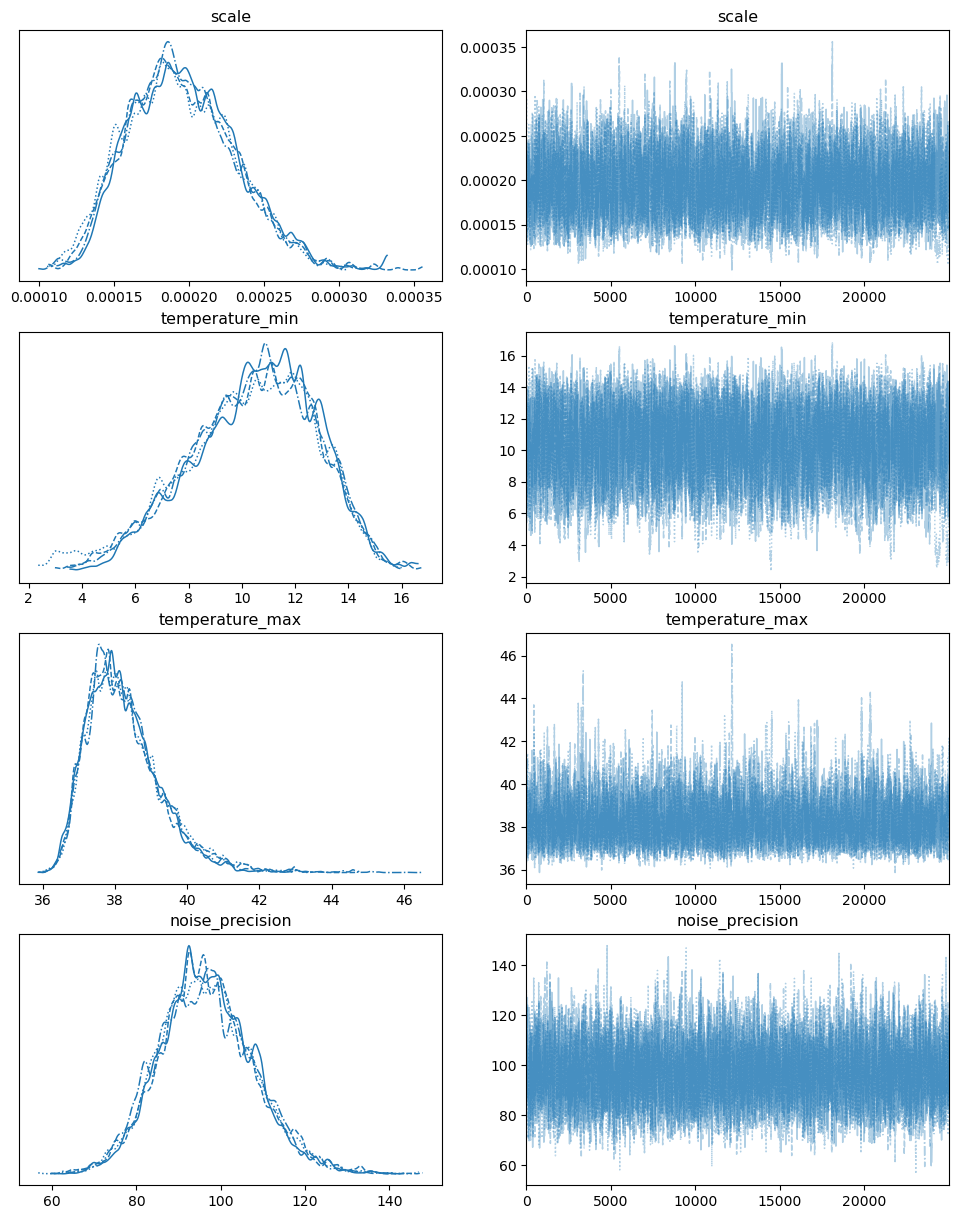

In [7]:
plots = az.plot_trace(idata_dict["biting_rate"], figsize=(12, 15))

In [8]:
for parameter_name, idata in idata_dict.items():
    print(f"Trait '{parameter_name}'")
    rhat = az.rhat(idata)
    ess = az.ess(idata)
    print(
        f"\tR-hat values: {rhat.scale.item():.3f} (scale), "
        f"{rhat.temperature_min.item():.3f} (min temp), "
        f"{rhat.temperature_max.item():.3f} (max temp), "
        f"{rhat.noise_precision.item():.3f} (noise precision)"
    )
    print(
        f"\tEffective sample size values: {ess.scale.item():.0f} (scale), "
        f"{ess.temperature_min.item():.0f} (min temp), "
        f"{ess.temperature_max.item():.0f} (max temp), "
        f"{ess.noise_precision.item():.0f} (noise precision)"
    )

Trait 'eggs_per_female_per_cycle'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.000 (max temp), 1.000 (noise precision)
	Effective sample size values: 4527 (scale), 4035 (min temp), 5264 (max temp), 4783 (noise precision)
Trait 'egg_to_adult_development_rate'
	R-hat values: 1.001 (scale), 1.000 (min temp), 1.001 (max temp), 1.000 (noise precision)
	Effective sample size values: 4330 (scale), 4085 (min temp), 5114 (max temp), 6015 (noise precision)
Trait 'egg_to_adult_survival_probability'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.001 (max temp), 1.001 (noise precision)
	Effective sample size values: 6936 (scale), 6289 (min temp), 7245 (max temp), 6025 (noise precision)
Trait 'adult_lifespan'
	R-hat values: 1.001 (scale), 1.001 (min temp), 1.001 (max temp), 1.001 (noise precision)
	Effective sample size values: 3798 (scale), 4034 (min temp), 4081 (max temp), 5106 (noise precision)
Trait 'biting_rate'
	R-hat values: 1.003 (scale), 1.003 (min temp), 1.002 (max temp), 1.001 (no

The `plot_fitted_temperature_responses()` method can be used to visualise fitted
temperature responses for each trait. Note that the returned plot object is a
`holoviews` `Layout` object. Customizations can be applied to each panel using the
`opts()` method.

In [9]:
plots = suitability_model.plot_fitted_temperature_responses(
    temperature_vals=np.linspace(0, 50, 500), frame_width=300, frame_height=300
).cols(2)
plots[0].opts(
    ylim=(0, 120),
    legend_position="top_left",
    legend_opts={
        "location": (5, 240),
        "padding": 5,
    },
)
plots[1].opts(ylim=(0, 0.2), show_legend=False)
plots[2].opts(ylim=(0, 1), show_legend=False)
plots[3].opts(ylim=(0, 160), show_legend=False)
plots[4].opts(ylim=(0, 0.4), show_legend=False)
plots[5].opts(ylim=(0, 1), show_legend=False)
plots[6].opts(ylim=(0, 1), show_legend=False)
plots[7].opts(ylim=(0, 0.4), show_legend=False)
plots

:Layout
   .Overlay.I    :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Eggs per female per cycle)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.II   :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Egg to adult development rate)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.III  :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Egg to adult survival probability)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.IV   :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Adult lifespan)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.V    :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Biting rate)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.VI   :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Human to mosquito transmission probability)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.VII  :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Mosquito to human transmission probability)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)
   .Overlay.VIII :Overlay
      .Curve.Median_response               :Curve   [temperature]   (Extrinsic incubation rate)
      .Area.A_95_percent_credible_interval :Area   [temperature]   (lower,upper)
      .Scatter.I                           :Scatter   [temperature]   (trait)

## 3. Constructing suitability curves

We now use the `construct_suitability_table()` method to create a suitability table
containing posterior values of the relative reproduction number on a grid of temperature
values.

In [10]:
suitability_model.construct_suitability_table(
    temperature_vals=np.linspace(0, 50, 1000), num_samples=10000
)

<xarray.Dataset> Size: 80MB
Dimensions:      (temperature: 1000, sample: 10000)
Coordinates:
  * temperature  (temperature) float64 8kB 0.0 0.05005 0.1001 ... 49.95 50.0
  * sample       (sample) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    suitability  (temperature, sample) float64 80MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

The constructed suitability table includes a dimension 'sample', giving a separate
suitability values for each posterior sample. We use the `reduce()` method to compute
the mean and 2.5%/97.5% quantiles of the suitability at each temperature grid point,
rescaling each curve to the [0, 1] range (similar to Figure 2 in Mordecai *et al.*,
2017, although highest posterior density intervals were considered in that study).

In [11]:
(
    suitability_model.reduce(stat="mean", rescale=True).plot_suitability()
    * suitability_model.reduce(
        stat="quantile", quantile=0.025, rescale=True
    ).plot_suitability(color="red", line_dash="dashed")
    * suitability_model.reduce(
        stat="quantile", quantile=0.975, rescale=True
    ).plot_suitability(color="red", line_dash="dashed")
).opts(xlim=(10, 40), ylim=(0, 1))

:Overlay
   .Curve.I   :Curve   [temperature]   (Suitability)
   .Curve.II  :Curve   [temperature]   (Suitability)
   .Curve.III :Curve   [temperature]   (Suitability)

## 4. Temperature range permitting transmission

We use the `get_posterior_min_optimal_max_temperature()` method to obtain posterior
estimates of the minimum/maximum temperature limits for transmission is possible (i.e.,
the range of temperatures for which the suitability value is above zero), as well as the
optimal temperature at which suitability is maximized.

In [12]:
ds_posterior_min_optimal_max = (
    suitability_model.get_posterior_min_optimal_max_temperature(suitability_threshold=0)
)
ds_posterior_min_optimal_max

<xarray.Dataset> Size: 320kB
Dimensions:              (sample: 10000)
Coordinates:
  * sample               (sample) int64 80kB 0 1 2 3 4 ... 9996 9997 9998 9999
Data variables:
    temperature_min      (sample) float64 80kB 17.94 13.24 15.49 ... 16.24 15.74
    temperature_optimal  (sample) float64 80kB 25.68 25.03 25.63 ... 25.88 23.77
    temperature_max      (sample) float64 80kB 31.26 30.76 31.21 ... 31.31 28.3

We use the `hvplot` library to visualize posterior distributions of the minimum, maximum
and optimal temperature values (similar to Figure 2 in Mordecai *et al.*, 2017).

In [13]:
(
    ds_posterior_min_optimal_max["temperature_min"].hvplot.hist()
    + ds_posterior_min_optimal_max["temperature_optimal"].hvplot.hist()
    + ds_posterior_min_optimal_max["temperature_max"].hvplot.hist()
).cols(1)

:Layout
   .NdOverlay.I   :NdOverlay   [Variable]
      :Histogram   [temperature_min]   (Count)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Histogram   [temperature_optimal]   (Count)
   .NdOverlay.III :NdOverlay   [Variable]
      :Histogram   [temperature_max]   (Count)

Finally, we compute posterior mean values and credible intervals of the minimum,
maximum and optimal temperatures.

In [14]:
ds_mean = ds_posterior_min_optimal_max.mean()
ds_lower = ds_posterior_min_optimal_max.quantile(0.025)
ds_upper = ds_posterior_min_optimal_max.quantile(0.975)
print("Posterior means (credible intervals):")
print(
    f"  Minimum suitable temperature: {ds_mean['temperature_min']:.1f}°C "
    f"({ds_lower['temperature_min']:.1f}, {ds_upper['temperature_min']:.1f})"
)
print(
    f"  Optimal temperature for transmission: {ds_mean['temperature_optimal']:.1f}°C "
    f"({ds_lower['temperature_optimal']:.1f}, {ds_upper['temperature_optimal']:.1f})"
)
print(
    f"  Maximum suitable temperature: {ds_mean['temperature_max']:.1f}°C "
    f"({ds_lower['temperature_max']:.1f}, {ds_upper['temperature_max']:.1f})"
)

Posterior means (credible intervals):
  Minimum suitable temperature: 15.9°C (12.9, 19.4)
  Optimal temperature for transmission: 25.5°C (24.6, 26.6)
  Maximum suitable temperature: 31.3°C (29.3, 32.9)
